In [1]:
import time
import functools
import multiprocessing
from pathlib import Path
from copy import deepcopy
from collections import defaultdict

import numpy as np

from scipy import integrate

from astropy import units as u
from astropy import table
from astropy.io import fits
from astropy.modeling import models, fitting

from astroquery.svo_fps import SvoFps


from specutils import Spectrum1D, manipulation

from astropy.visualization import quantity_support
quantity_support()

from matplotlib import pyplot as plt

from tqdm.auto import tqdm

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
tensor_dtype = torch.float32
if device == 'cpu':
    tensor_dtype = torch.float64
print(f"Using {device} device with dtype {tensor_dtype}")

Using cuda device with dtype torch.float32


In [3]:
datapath = Path('../fullgrid/')

# Load Data

Mostly taken from [resampling_tensors.ipynb](resampling_tensors.ipynb)

In [4]:
wlspath = datapath / 'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits'

wlsraw = fits.getdata(wlspath)
model_wls = wlsraw << u.Unit(fits.getheader(wlspath)['UNIT'])

model_wls, len(model_wls)

(<Quantity [  500.  ,   500.1 ,   500.2 , ..., 54999.25, 54999.5 , 54999.75] Angstrom>,
 1569128)

In [5]:
allspecpaths = list(datapath.glob('lte*HiRes.fits'))
len(allspecpaths)

7559

But some of them have no BUINT, it turns out those are wrong in an unclear way so we skip them.

In [6]:
goodspecmask = np.array(['BUNIT' in fits.getheader(p) for p in tqdm(allspecpaths)])
goodspecpaths = [p for i,p in enumerate(allspecpaths) if goodspecmask[i]]
assert len(goodspecpaths) == np.sum(goodspecmask)

  0%|          | 0/7559 [00:00<?, ?it/s]

In [7]:
specunit = u.Unit(fits.getval(goodspecpaths[0], 'BUNIT'))

# Pick bands and wavelength range

This sets up a wavelength range for interpolation that spans a specific set of photometic bands at a wavelength spacing that is not-crazy for the filter responses available.

In [8]:
phottab = table.Table.read('spectrophotometry.ecsv', format='ascii.ecsv')
phottab.colnames

['specname',
 'absmag_F275W_vega',
 'absmag_F275W_AB',
 'absmag_F275W_ST',
 'absmag_F336W_vega',
 'absmag_F336W_AB',
 'absmag_F336W_ST',
 'absmag_F475W_vega',
 'absmag_F475W_AB',
 'absmag_F475W_ST',
 'absmag_F814W_vega',
 'absmag_F814W_AB',
 'absmag_F814W_ST',
 'absmag_F110W_vega',
 'absmag_F110W_AB',
 'absmag_F110W_ST',
 'absmag_F160W_vega',
 'absmag_F160W_AB',
 'absmag_F160W_ST']

In [9]:
filters = ['HST/WFC3_UVIS1.F275W', 'HST/WFC3_UVIS1.F336W', 
           'HST/ACS_WFC.F475W', 'HST/ACS_WFC.F814W', 
           'HST/WFC3_IR.F110W', 'HST/WFC3_IR.F160W']

transmission = {filtname.split('.')[-1]:SvoFps.get_transmission_data(filtname) for filtname in filters}

In [10]:
wls = [u.Quantity(ttab['Wavelength'], u.angstrom) for ttab in transmission.values()]

dwls = []
for wl in wls:
    dwls.append(np.diff(wl))
dwls = np.concatenate(dwls)

qs = np.quantile(dwls, [.01, .05, .1, .5, .9])
qs

<Quantity [4.880000e-04, 4.995120e-01, 5.000000e-01, 5.000000e-01,
           3.592285e+00] Angstrom>

In [11]:
dwl = qs[2]
dwl

<Quantity 0.5 Angstrom>

In [12]:
minwl = np.concatenate(wls).min()
maxwl = np.concatenate(wls).max()
minwl, maxwl

(<Quantity 2161. Angstrom>, <Quantity 17204.697266 Angstrom>)

In [13]:
minwl

<Quantity 2161. Angstrom>

In [14]:
(minwl.to(u.angstrom), maxwl.to(u.angstrom), dwl.to(u.angstrom))

(<Quantity 2161. Angstrom>,
 <Quantity 17204.697266 Angstrom>,
 <Quantity 0.5 Angstrom>)

In [15]:
(maxwl-minwl)//dwl  + 1

<Quantity 30088.>

In [16]:
fine_wl = np.linspace(minwl.to(u.angstrom)*.99, maxwl.to(u.angstrom)*1.01, int((maxwl*1.01-minwl*.99)//dwl  + 1))
len(fine_wl)

30475

that's way too fine to realistically train.  Lets try shrinking it down for now and see if it works ok anyway.

In [17]:
data_wls = fine_wl[::10]
len(data_wls)

3048

# Do the interpolation to more reasonable-size spectra

note this caches the result in `fluxes.pt`.  Delete the file to re-compute

In [18]:
fluxes = None
if Path('fluxes.pt').is_file():
    fluxes = torch.load('fluxes.pt', weights_only=True)

In [19]:
if fluxes is None:
    resampler = manipulation.FluxConservingResampler()
    
    def interpolate_and_return_flux(specpath, data_wls=data_wls, resampler=resampler):
        header = dict(fits.getheader(specpath, ext=0))
        spec = Spectrum1D(spectral_axis=model_wls, flux=fits.getdata(specpath, ext=0) << u.Unit(header['BUNIT']))
        newspec = resampler(spec, data_wls)
    
        return newspec.flux.value
    
    with multiprocessing.Pool(16) as pool:
          results = list(tqdm(pool.imap(interpolate_and_return_flux, goodspecpaths), total=len(goodspecpaths)))
        
    fluxes = torch.from_numpy(np.array(results))
    torch.save(fluxes, 'fluxes.pt')

fluxes.shape

torch.Size([7508, 3048])

In [20]:
teff = torch.tensor([fits.getval(p, 'PHXTEFF') for p in goodspecpaths])
logg = torch.tensor([fits.getval(p, 'PHXLOGG') for p in goodspecpaths])
feh = torch.tensor([fits.getval(p, 'PHXM_H') for p in goodspecpaths])

infeatures = torch.stack([teff,logg,feh], dim=1)
infeature_names = 'Teff,logg,FeH'.split(',')

In [21]:
infeatures[-45], phottab['specname'][-45]

(tensor([ 1.2000e+04,  3.5000e+00, -3.0000e+00]), np.str_('lte12000-3.50-3.0'))

Whew, they are aligned

See [photometry_from_restricted_mlp.ipnb](photometry_from_restricted_mlp.ipnb) for backstory on this polynomial blackbody scaling fit

In [23]:
uteffs = np.unique(teff)*u.K
bb = models.BlackBody(temperature=uteffs, scale=1*u.erg/u.s * u.cm**-3 / u.sr)
wlx10 = np.linspace(data_wls[0], data_wls[-1], len(data_wls)*10)
flux = bb(wlx10[..., None])*(np.pi*u.sr)
mf = np.mean(flux, axis=0)

teffpoly = fitting.LinearLSQFitter()(models.Polynomial1D(6), np.log10(uteffs/u.K), np.log10(mf.value))

percerror = 10**teffpoly(np.log10(uteffs/u.K))/mf.value - 1
teffpoly, np.mean(percerror), np.std(percerror)

(<Polynomial1D(6, c0=8366.13250623 , c1=-13866.35648022 , c2=9519.88701007 , c3=-3465.35091671 , c4=705.99040231 , c5=-76.35115396 , c6=3.42507771 )>,
 <Quantity 5.42194705e-09>,
 <Quantity 0.00010491>)

In [56]:
phottensors = []
bandnms = 'F275W,F336W,F475W,F814W,F110W,F160W'.split(',')
for bandnm in bandnms:
    phottensors.append(torch.from_numpy(phottab[f'absmag_{bandnm}_AB']))
    
phottensors = torch.vstack(phottensors).T.to(device, dtype=tensor_dtype)
phottensors.shape

torch.Size([7508, 6])

# Create the Model

The model here is a few layered components:
* MLP from the input feature space to some fixed size restricted "latent-like" space.
* A resnet-style expansion from the latent space to the pixel space

In [132]:
class SpecPhotEmulator(nn.Module):
    def __init__(self, feature_mlp_nneurons, resnet_nneurons, phot_nneurons, teffindex=0, 
                       logifyteff=False, data_wls=data_wls, activation_cls=nn.GELU):
        """
        output pixels implicitly set by data_wls, input by first of feature_mlp_nneurons
        phot_nneurons must start with 
        """
        super().__init__()

        self.data_wls = data_wls.to(u.angstrom)
        self.teffindex = teffindex
        self.logifyteff = logifyteff
        
        noutpixels = len(data_wls)

        mlp_layers = []
        for ni, no in zip(feature_mlp_nneurons[:-1], feature_mlp_nneurons[1:]):
            mlp_layers.append(nn.Linear(ni, no))
            mlp_layers.append(activation_cls())


        self.mlp = nn.Sequential(*mlp_layers)

        assert feature_mlp_nneurons[-1] == resnet_nneurons[0], 'the mlp must end with the same number of neurons as the resnet starts with!' 
        assert resnet_nneurons[0] == resnet_nneurons[-1], 'the resnet must start and end at the same number of neurons'
        assert feature_mlp_nneurons[-1] == phot_nneurons[0], 'the mlp must end with the same number of neurons as the phot net starts with!' 

        res_layers = []
        for ni, no in zip(resnet_nneurons[:-1], resnet_nneurons[1:]):
            res_layers.append(nn.Linear(ni, no))
            res_layers.append(activation_cls())
        
        self.resishnet = nn.Sequential(*res_layers)

        self.specoutputnet = nn.Sequential(nn.Linear(resnet_nneurons[-1], noutpixels),
                                       activation_cls(),
                                       nn.Linear(noutpixels, noutpixels),
                                      )

        
        phot_layers = []
        for ni, no in zip(phot_nneurons[:-1], phot_nneurons[1:]):
            phot_layers.append(nn.Linear(ni, no))
            phot_layers.append(activation_cls())
        del phot_layers[-1] # last layer should have no activation
        self.photnet = nn.Sequential(*phot_layers)

        self.optimizer_cls = torch.optim.AdamW
        self.scheduler_init = None

        self.spec_weight = self.phot_weight = 0.5
        self.spec_loss_fcn = nn.MSELoss()
        self.phot_loss_fcn = nn.MSELoss()

    @property
    def device(self):
        return next(self.parameters()).device         

    @property
    def dtype(self):
        return next(self.parameters()).dtype

    def bbscale(self, flux, teff):
        bbmean = self.bbmean(teff)
        y = flux/bbmean - 1
        return y

    def bbunscale(self, y, teff):
        bbmean = self.bbmean(teff)
        flux = (y + 1) * bbmean
        return flux

    def bbmean(self, teff):
        # fast approximation from above
        if isinstance(teff, u.Quantity):
            teff = teff/u.K
        if isinstance(teff, torch.Tensor):
            teff = teff.to('cpu')
        res = 10**teffpoly(np.log10(teff))
        return self.convert_input(torch.from_numpy(res.value))
        
    def bbmean_direct(self, teff):
        """
        teff should be scalar or 1d
        """
        # TODO: implement caching if needed
        bb = models.BlackBody(temperature=teff, scale=1*u.erg/u.s * u.cm**-3 / u.sr)
        flux = bb(self.data_wls[..., None])*(np.pi*u.s)
        return flux.mean(axis=0)

    def convert_input(self, t):
        t = torch.atleast_2d(t)
        return t.to(self.device, dtype=self.dtype)

    def forward(self, x, in_convert=True):
        """
        the output is not descaled here, use `forward_descale` if that's what's desired
        """
        if in_convert:
            x = self.convert_input(x)
        
        if self.logifyteff:
            x = x.clone()
            x[..., self.teffindex] = torch.log10(x[..., self.teffindex])
    
        ym = self.mlp(x)
        yr = self.resishnet(ym)
        specout = self.specoutputnet(yr + ym)

        photout = self.photnet(ym)
        
        return specout, photout
            
    def forward_descale(self, x, in_convert=True):
        if in_convert:
            x = self.convert_input(x)
        ys, yp = self.forward(x)
        return self.bbunscale(ys, x[..., self.teffindex]), yp

    def forward_phot_only(self, x, in_convert=True):
        if in_convert:
            x = self.convert_input(x)
        
        if self.logifyteff:
            x = x.clone()
            x[..., self.teffindex] = torch.log10(x[..., self.teffindex])

        return self.photnet(self.mlp(x))

    def loss_fcn(self, predsp, Ys, Yp):
        preds, predp = predsp
        specloss = self.spec_loss_fcn(preds, Ys)
        photloss = self.phot_loss_fcn(predp, Yp)
        return self.spec_weight * specloss + self.phot_weight * photloss
        

    def train_and_validate(self, infeatures, fluxes, phot, nepochs, batch_size,
                                 tetrsplit=[.3, .7], split_seed=42, optkwargs={}, shuffle_batches=True):
        inteff = infeatures[..., self.teffindex][..., None]
        scaled_fluxes = self.bbscale(self.convert_input(fluxes), inteff)
        dataset = TensorDataset(self.convert_input(infeatures), scaled_fluxes, phot)
        
        split_data = random_split(dataset, tetrsplit, torch.Generator().manual_seed(split_seed))
        valid_data, train_data = split_data

        optimizer = self.optimizer_cls(self.parameters(), **optkwargs)
        if self.scheduler_init is not None:
            scheduler = self.scheduler_init(optimizer)
            
        niters = 0
        valid_losses = []
        valid_niters = []    
        train_losses = []
        train_niters = []
        lrs = []

        valid_x = valid_data.dataset.tensors[0][valid_data.indices]
        valid_ys = valid_data.dataset.tensors[1][valid_data.indices]
        valid_yp = valid_data.dataset.tensors[2][valid_data.indices]
        def validation_fcn():
            self.eval()
            with torch.no_grad():
                pred = self(valid_x, in_convert=False)
                valid_loss = self.loss_fcn(pred, valid_ys, valid_yp).item()
                valid_losses.append(valid_loss)
                valid_niters.append(niters)
            return valid_loss

        for _ in (pbar := tqdm(range(nepochs))):
            self.train()

            for data in DataLoader(train_data, batch_size=batch_size, shuffle=shuffle_batches):
                X, Ys, Yp = data[:3]
                optimizer.zero_grad()
                
                pred = self(X, in_convert=False)
                loss = self.loss_fcn(pred, Ys, Yp)
                
                loss.backward()
                optimizer.step()
        
                niters += X.shape[0]
                
                train_losses.append(loss.item())
                train_niters.append(niters)

            if self.scheduler_init is not None:
                scheduler.step()
                lrs.append(scheduler.get_last_lr())
            valid_loss = validation_fcn()
            if self.scheduler_init  is None:
                pbar.set_description(f'valid loss={valid_loss:.3e}')
            else:
                pbar.set_description(f'valid loss={valid_loss:.3e}, lr={lrs[-1][0]:.3e}')

        return (valid_niters, valid_losses), (train_niters, train_losses), lrs, split_data
        

In [133]:
def plot_sample_specs(model, dataset_to_plot, idxs=5, descale=False, wlrng=(14000*u.angstrom, 15000*u.angstrom)):
    if isinstance(idxs, int):
        idxs = np.random.randint(len(dataset_to_plot), size=5)

    wl = model.data_wls

    figs = []
    for idx in idxs:
        true_idx = dataset_to_plot.indices[idx]
        Xi, Yi, Ypi = [xy[true_idx] for xy in dataset_to_plot.dataset.tensors]
        
        pred, predp = model(Xi[None,...])
        pred = pred[0].detach()
        predp = predp[0].detach()
        if descale:
            teffs = model.convert_input(Xi[..., model.teffindex][..., None])
            pred = model.bbunscale(pred, teffs)[0]
            Yi = model.bbunscale(Yi, teffs)[0]
            
        fig, axs = plt.subplots(1, 3, figsize=(12, 6))
        figs.append(fig)
        ax1, ax2, ax3 = axs
        
        ax1.plot(wl, Yi.cpu(), lw=1, label='true')
        ax1.plot(wl, pred.cpu(), lw=1, label='predicted', alpha=.5)
        ax1.legend(loc=0)
        ax1.set_title(f'{idx}')
        
        msk = (wlrng[0]<model.data_wls)&(model.data_wls<wlrng[1])
        ax2.plot(wl[msk], Yi[msk].cpu(), lw=1, label='true')
        ax2.plot(wl[msk], pred[msk].cpu(), lw=1, label='predicted', alpha=.5)
        ax2.legend(loc=0)
        ax2.set_title(f'{true_idx} - zoom')
        
        ax3.scatter(np.arange(Ypi.shape[-1]), (Ypi - predp).cpu())
        ax3.set_xticks(np.arange(len(bandnms)), bandnms)
        ax3.set_ylabel('true - pred mag')
        
    return figs

In [134]:
nperrestart = 5000
nrestarts = 3

model = SpecPhotEmulator(feature_mlp_nneurons=[3, 8,   16, 64, 128, 256, 1024, 512, 256], 
                         resnet_nneurons=[ 256, 512, 8184, 512, 256 ],
                         phot_nneurons=[256, 1024, 512, 128, 64,  6],
                        logifyteff=True)
print(sum(p.shape.numel() for p in model.parameters()) * 1e-6, 'M parameters')

model = model.to(device, dtype=tensor_dtype)

model.scheduler_init = functools.partial(torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, T_0=nperrestart)

valid, train, lrs, data_split =  model.train_and_validate(infeatures, fluxes, phottensors, nperrestart*nrestarts, 1024,
                                                         optkwargs=dict(lr=1e-4, weight_decay=1e-3))

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
if lrs:
    plt.twinx()
    plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
    plt.ylabel('learning rate', color='C2')

plot_sample_specs(model, data_split[0])

20.552894 M parameters


/tmp/ipykernel_3858/778355952.py:79: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  res = 10**teffpoly(np.log10(teff))


  0%|          | 0/15000 [00:00<?, ?it/s]

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fda3b38a350>>
Traceback (most recent call last):
  File "/home/erik/astro/phoenix/ml_generation/.pixi/envs/cuda/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

In [87]:
modelca = model

14.713085999999999 M parameters


/tmp/ipykernel_3858/778355952.py:79: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  res = 10**teffpoly(np.log10(teff))


  0%|          | 0/2000 [00:00<?, ?it/s]

[<Figure size 1200x600 with 3 Axes>,
 <Figure size 1200x600 with 3 Axes>,
 <Figure size 1200x600 with 3 Axes>,
 <Figure size 1200x600 with 3 Axes>,
 <Figure size 1200x600 with 3 Axes>]

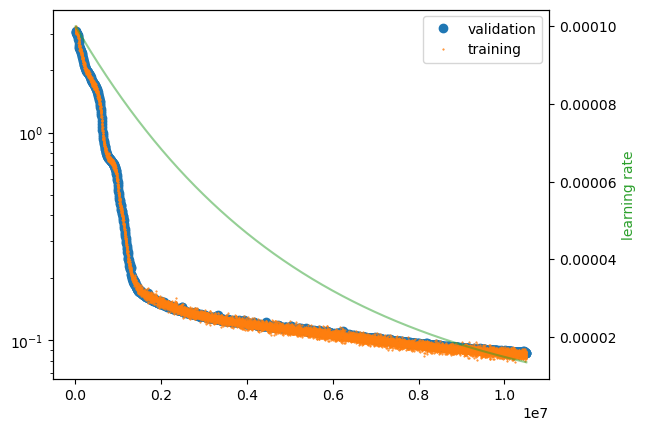

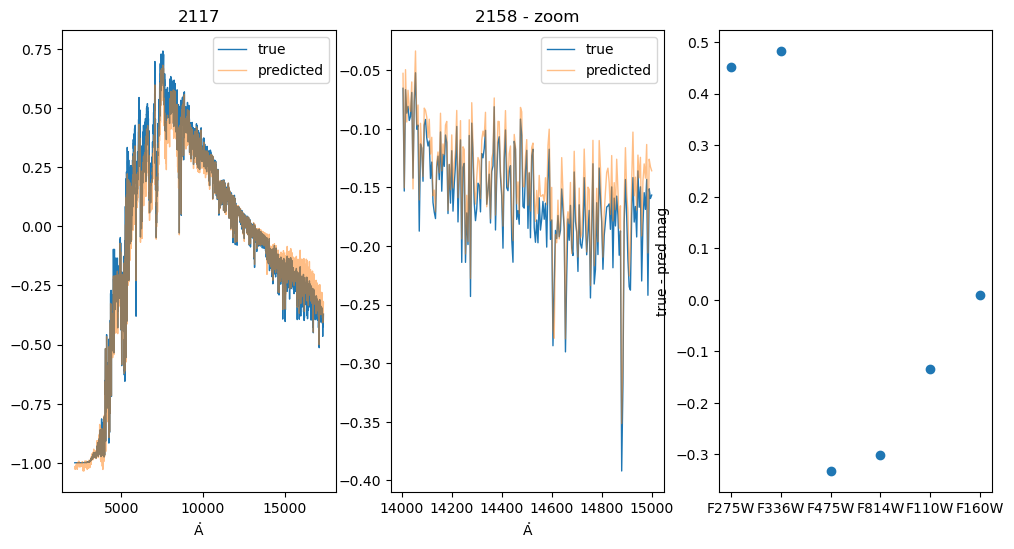

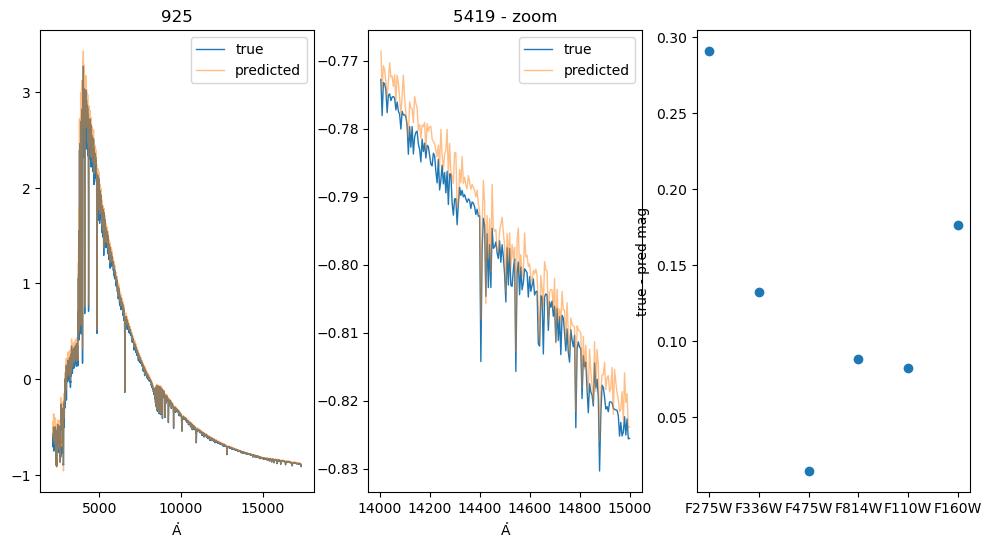

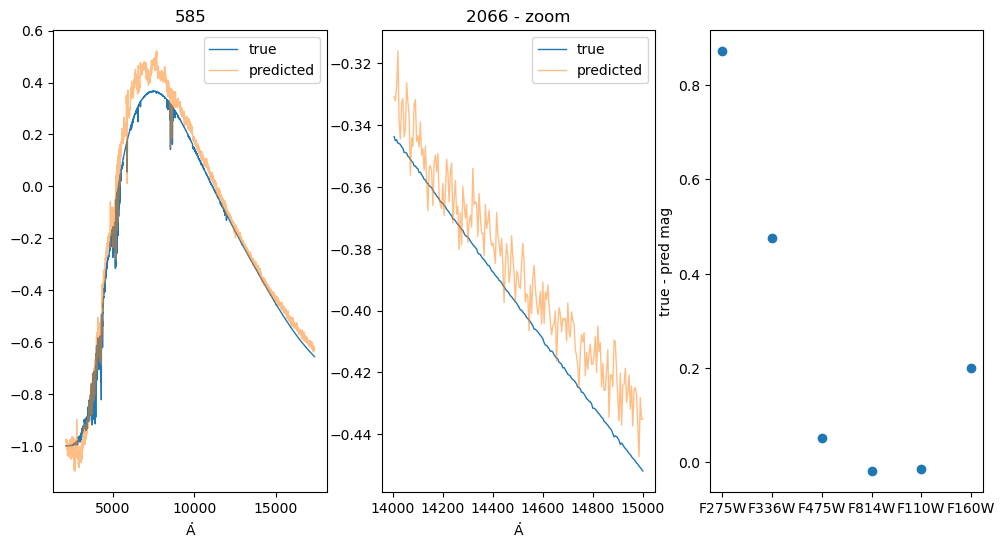

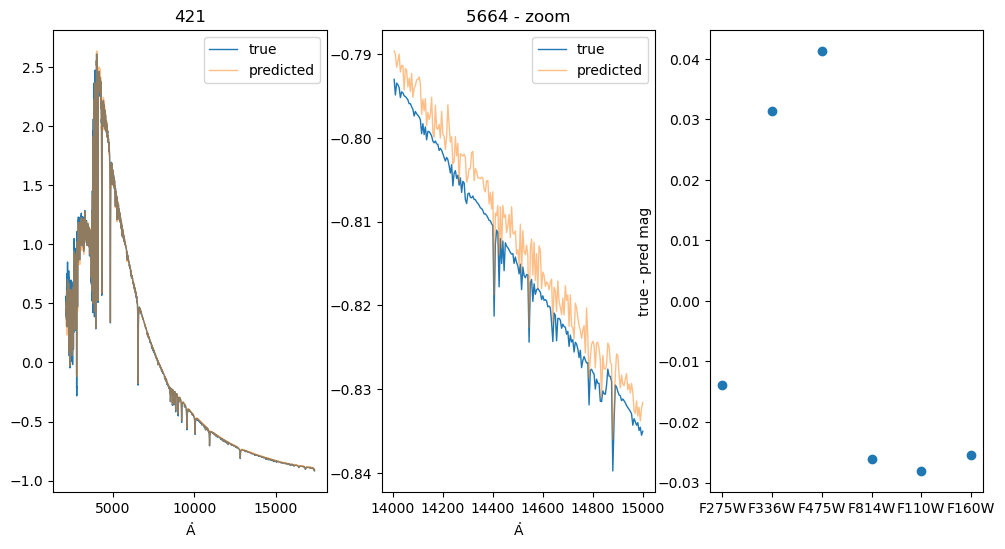

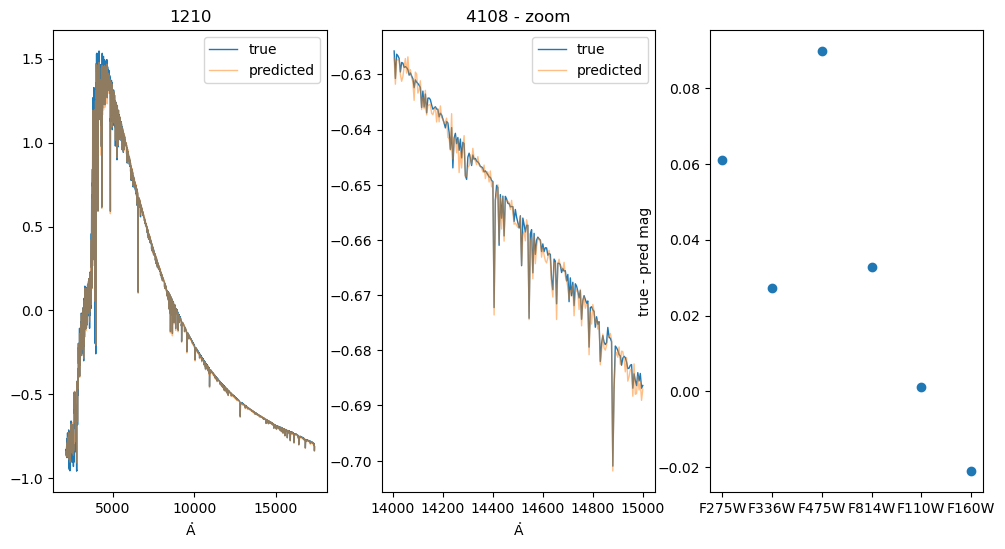

In [135]:
nperrestart = 2000
nrestarts = 1

model = SpecPhotEmulator(feature_mlp_nneurons=[3, 8,   16, 64, 128,  256], 
                         resnet_nneurons=[ 256, 8184, 256 ],
                         phot_nneurons=[256, 1024, 128,   6],
                        logifyteff=True)
print(sum(p.shape.numel() for p in model.parameters()) * 1e-6, 'M parameters')

model = model.to(device, dtype=tensor_dtype)

model.spec_loss_fcn = nn.L1Loss()
model.phot_loss_fcn = nn.L1Loss()

model.scheduler_init = functools.partial(torch.optim.lr_scheduler.ExponentialLR, gamma=.999)

valid, train, lrs, data_split =  model.train_and_validate(infeatures, fluxes, phottensors, nperrestart*nrestarts, int(np.ceil(fluxes.shape[0]/7)),
                                                         optkwargs=dict(lr=1e-4, weight_decay=0))

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
if lrs:
    plt.twinx()
    plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
    plt.ylabel('learning rate', color='C2')

plot_sample_specs(model, data_split[0])

The photometry never really fits?